# Convolutional Neural Networks for Classifying Fashion-MNIST Dataset using Ignite
This is a tutorial on using Ignite to train neural network models, setup experiments and validate models.

In this notebook, we will be doing classification of images using Convolutional Neural Networks 

We will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) Fashion-MNIST is a set of 28x28 grayscale images of clothes.

![Fashion MNIST dataset](https://github.com/abdulelahsm/ignite/blob/update-tutorials/examples/notebooks/assets/fashion-mnist.png?raw=1)

Lets get started!

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Required Dependencies

We assume that `torch` and `ignite` are already installed. We can install it using `pip`:

In [2]:
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 7.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Importing libraries

General Data-Science Libraries like numpy, matplotlib and seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

We import `torch`, `nn` and `functional` modules to create our models.

We also import `datasets` and `transforms` from torchvision for loading the dataset and applying transforms to the images in the dataset.

We import `Dataloader` for making train and validation loader for loading data into our model.

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

`Ignite` is a High-level library to help with training neural networks in PyTorch. It comes with an `Engine` to setup a training loop, various metrics, handlers and a helpful contrib section! 

Below we import the following:
* **Engine**: Runs a given process_function over each batch of a dataset, emitting events as it goes.
* **Events**: Allows users to attach functions to an `Engine` to fire functions at a specific event. Eg: `EPOCH_COMPLETED`, `ITERATION_STARTED`, etc.
* **Accuracy**: Metric to calculate accuracy over a dataset, for binary, multiclass, multilabel cases. 
* **Loss**: General metric that takes a loss function as a parameter, calculate loss over a dataset.
* **RunningAverage**: General metric to attach to Engine during training. 
* **ModelCheckpoint**: Handler to checkpoint models. 
* **EarlyStopping**: Handler to stop training based on a score function. 

In [5]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

The code below first sets up transform using `torhvision transfroms` for converting images to pytorch tensors and normalizing the images.

Next, We use `torchvision datasets` for dowloading the fashion mnist dataset and applying transforms which we defined above.

* `trainset` contains the training data.
* `validationset` contains the validation data

Next, We use `pytorch dataloader` for making dataloader from the train and validation sets.

In [6]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
val_loader = DataLoader(validationset, batch_size=64, shuffle=True)

In [7]:
'''
Copyright (C) 2020. Huawei Technologies Co., Ltd. All rights reserved.
This program is free software; you can redistribute it and/or modify
it under the terms of BSD 3-Clause License.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
BSD 3-Clause License for more details.
'''
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Function
import math

def adder2d_function(X, W, stride=1, padding=0):
    n_filters, d_filter, h_filter, w_filter = W.size()
    n_x, d_x, h_x, w_x = X.size()

    h_out = (h_x - h_filter + 2 * padding) / stride + 1
    w_out = (w_x - w_filter + 2 * padding) / stride + 1

    h_out, w_out = int(h_out), int(w_out)
    X_col = torch.nn.functional.unfold(X.view(1, -1, h_x, w_x), h_filter, dilation=1, padding=padding, stride=stride).view(n_x, -1, h_out*w_out)
    X_col = X_col.permute(1,2,0).contiguous().view(X_col.size(1),-1)
    W_col = W.view(n_filters, -1)
    
    out = adder.apply(W_col,X_col)
    
    out = out.view(n_filters, h_out, w_out, n_x)
    out = out.permute(3, 0, 1, 2).contiguous()
    
    return out

class adder(Function):
    @staticmethod
    def forward(ctx, W_col, X_col):
        ctx.save_for_backward(W_col,X_col)
        output = -(W_col.unsqueeze(2)-X_col.unsqueeze(0)).abs().sum(1)
        return output

    @staticmethod
    def backward(ctx,grad_output):
        W_col,X_col = ctx.saved_tensors
        grad_W_col = ((X_col.unsqueeze(0)-W_col.unsqueeze(2))*grad_output.unsqueeze(1)).sum(2)
        grad_W_col = grad_W_col/grad_W_col.norm(p=2).clamp(min=1e-12)*math.sqrt(W_col.size(1)*W_col.size(0))/5
        grad_X_col = (-(X_col.unsqueeze(0)-W_col.unsqueeze(2)).clamp(-1,1)*grad_output.unsqueeze(1)).sum(0)
        
        return grad_W_col, grad_X_col
    
class adder2d(nn.Module):

    def __init__(self,input_channel,output_channel,kernel_size, stride=1, padding=0, bias = False):
        super(adder2d, self).__init__()
        self.stride = stride
        self.padding = padding
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.adder = torch.nn.Parameter(nn.init.normal_(torch.randn(output_channel,input_channel,kernel_size,kernel_size)))
        self.bias = bias
        if bias:
            self.b = torch.nn.Parameter(nn.init.uniform_(torch.zeros(output_channel)))

    def forward(self, x):
        output = adder2d_function(x,self.adder, self.stride, self.padding)
        if self.bias:
            output += self.b.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        
        return output
    
    

### CNN Model

Explanation of Model Architecture

* [Convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), the Convolutional layer is used to create a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
* [Maxpooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), the Maxpooling layer is used to downsample an input representation keeping the most active pixels from the previous layer.
* The usual [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) + [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) layers to avoid overfitting and produce a 10-dim output.
* We had used [Relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) Non Linearity for the model and [logsoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) at the last layer because we are going to use the [NLLL loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html).


In [8]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.beta = 0.95
        self.spike_grad = surrogate.fast_sigmoid(slope=25)
        self.num_steps = 20
        
        self.convlayer1 = nn.Sequential(
            adder2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.lif1 = snn.Leaky(beta=self.beta, learn_beta=True, learn_threshold=True, spike_grad = self.spike_grad) 
        
        self.convlayer2 = nn.Sequential(
            adder2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.lif2 = snn.Leaky(beta=self.beta, learn_beta=True, learn_threshold=True, spike_grad = self.spike_grad) 
        
        self.fc1 = nn.Linear(64*6*6,600)         
        self.drop = nn.Dropout2d(0.25)
        self.lif3 = snn.Leaky(beta=self.beta, learn_beta=True, learn_threshold=True, spike_grad = self.spike_grad)
        self.fc2 = nn.Linear(600, 120)
        self.lif4 = snn.Leaky(beta=self.beta, learn_beta=True, learn_threshold=True, spike_grad = self.spike_grad)
        self.fc3 = nn.Linear(120, 10)
        self.lif5 = snn.Leaky(beta=self.beta, learn_beta=True, learn_threshold=True, spike_grad = self.spike_grad)
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        
        spk5_rec = []
        mem5_rec = []          
        
        for step in range(self.num_steps):  
            x1 = self.convlayer1(x)
            x1 , mem1 = self.lif1(x1, mem1)
            x1  = self.convlayer2(x1)
            x1 , mem2 = self.lif2(x1, mem2)
            x1  = x1 .view(-1,64*6*6)
            x1  = self.fc1(x1)
            x1 = self.drop(x1)
            x1, mem3 = self.lif3(x1, mem3)
            x1 = self.fc2(x1)
            x1, mem4 = self.lif4(x1, mem4)
            x1 = self.fc3(x1)
            x1, mem5 = self.lif5(x1, mem5)
            
            spk5_rec.append(x1)
            mem5_rec.append(mem5)             
            
        spikes = torch.stack(spk5_rec, dim=0).view(self.num_steps, batch_size, 10).sum(dim=0)            
        
        return F.log_softmax(spikes,dim=1)

### Creating Model, Optimizer and Loss

Below we create an instance of the CNN model. The model is placed on a device and then a loss function of `negative log likelihood loss` and `Adam optimizer` with learning rate of 0.001 are setup. 

In [9]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()
print(device)

cuda:0


### Training and Evaluating using Ignite

### Instantiating Training and Evaluating Engines

Below we create 3 engines, a trainer, an evaluator for the training set and an evaluator for the validation set, by using the `create_supervised_trainer` and `create_supervised_evaluator` and passing the required arguments.

We import the metrics from `ignite.metrics` which we want to calculate for the model. Like `Accuracy`, `ConfusionMatrix`, and `Loss` and we pass them to `evaluator` engines which will calculate these metrics for each iteration.

* `training_history`: it stores the training loss and accuracy
* `validation_history`:it stores the validation loss and accuracy
* `last_epoch`: it stores the last epoch untill the model is trained


In [10]:
# defining the number of epochs
epochs = 12
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

### Metrics - RunningAverage

To start, we will attach a metric of `RunningAverage` to track a running average of the scalar loss output for each batch. 

In [11]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

### EarlyStopping - Tracking Validation Loss

Now we will setup a `EarlyStopping` handler for this training process. EarlyStopping requires a score_function that allows the user to define whatever criteria to stop trainig. In this case, if the loss of the validation set does not decrease in 10 epochs, the training process will stop early. Since the `EarlyStopping` handler relies on the validation loss, it's attached to the `val_evaluator`. 

In [12]:
def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

### Attaching Custom Functions to Engine at specific Events

Below you will see ways to define your own custom functions and attaching them to various `Events` of the training process.

The functions below both achieve similar tasks, they print the results of the evaluator run on a dataset. One function does that on the training evaluator and dataset, while the other on the validation. Another difference is how these functions are attached in the trainer engine.

The first method involves using a decorator, the syntax is simple - `@` `trainer.on(Events.EPOCH_COMPLETED)`, means that the decorated function will be attached to the trainer and called at the end of each epoch. 

The second method involves using the add_event_handler method of trainer - `trainer.add_event_handler(Events.EPOCH_COMPLETED, custom_function)`. This achieves the same result as the above. 

In [13]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)    

### Confusion Matrix

Confusion matrix gives us a better idea of what our classification model is getting right and what types of errors it is making.

We visualize the `confusion matrix` using the `seaborn.heatmap` from `seaborn` library.

In [14]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    fig, ax = plt.subplots(figsize=(10,10))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

### ModelCheckpoint

Lastly, we want to checkpoint this model. It's important to do so, as training processes can be time consuming and if for some reason something goes wrong during training, a model checkpoint can be helpful to restart training from the point of failure.

Below we will use Ignite's `ModelCheckpoint` handler to checkpoint models at the end of each epoch.

In [15]:
checkpointer = ModelCheckpoint('./saved_models', 'fashionMNIST', n_saved=2, create_dir=True,require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'fashionMNIST': model})

### Run Engine

Next, we will run the trainer for 12 epochs and monitor results. Below we can see that custom functions defined above helps prints the `loss` and `accuracy` per epoch.  


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training Results - Epoch: 1  Avg accuracy: 66.78 Avg loss: 0.82
Validation Results - Epoch: 1  Avg accuracy: 66.11 Avg loss: 0.84
Training Results - Epoch: 2  Avg accuracy: 73.90 Avg loss: 0.68
Validation Results - Epoch: 2  Avg accuracy: 72.73 Avg loss: 0.72
Training Results - Epoch: 3  Avg accuracy: 78.63 Avg loss: 0.59
Validation Results - Epoch: 3  Avg accuracy: 78.21 Avg loss: 0.62
Training Results - Epoch: 4  Avg accuracy: 81.50 Avg loss: 0.50
Validation Results - Epoch: 4  Avg accuracy: 80.62 Avg loss: 0.53
Training Results - Epoch: 5  Avg accuracy: 83.03 Avg loss: 0.47
Validation Results - Epoch: 5  Avg accuracy: 81.81 Avg loss: 0.51
Training Results - Epoch: 6  Avg accuracy: 84.08 Avg loss: 0.45
Validation Results - Epoch: 6  Avg accuracy: 82.49 Avg loss: 0.49
Training Results - Epoch: 7  Avg accuracy: 84.89 Avg loss: 0.41
Validation Results - Epoch: 7  Avg accuracy: 83.46 Avg loss: 0.46
Training Results - Epoch: 8  Avg accuracy: 83.55 Avg loss: 0.44
Validation Results - Epoch

State:
	iteration: 11256
	epoch: 12
	epoch_length: 938
	max_epochs: 12
	output: 0.15693293511867523
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

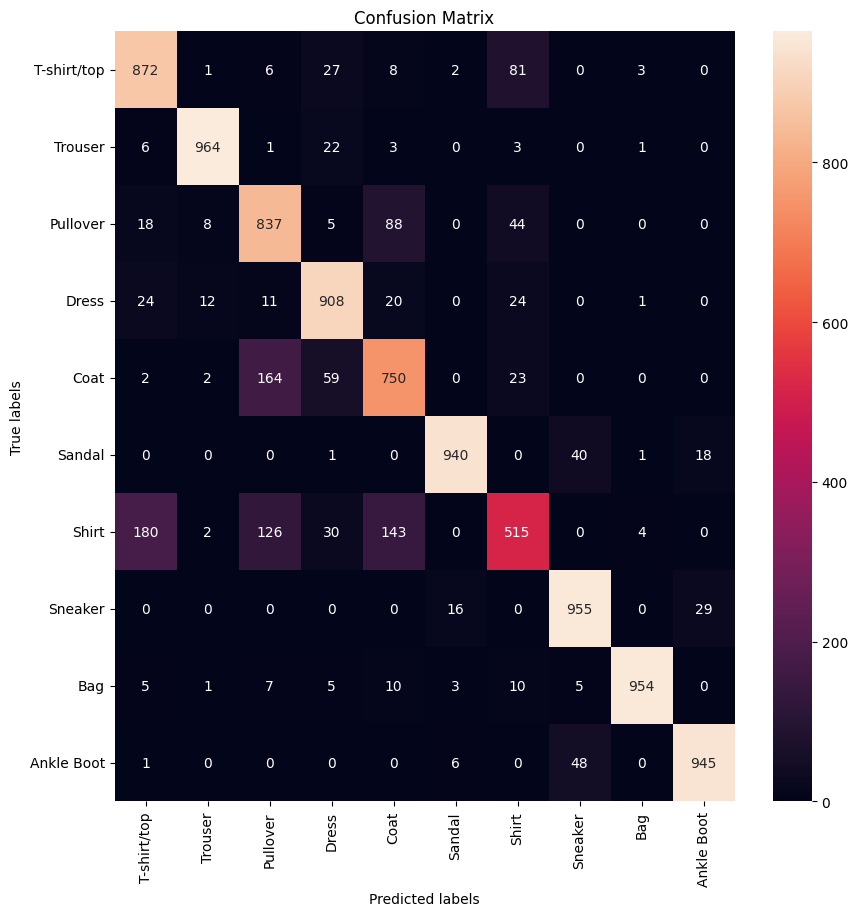

In [16]:
trainer.run(train_loader, max_epochs=epochs)

In [17]:
print(1)

1


### Plotting the loss and accuracy
Next, we will plot the loss and accuracy which we have stored in the `training_history` and `validation_history` dictionary to see how loss and accuracy are changing with each epoch.

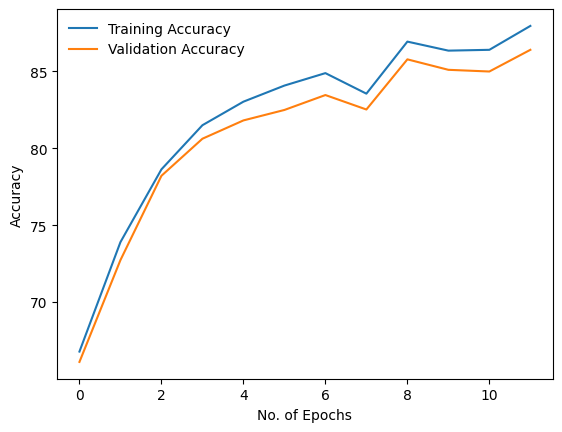

In [18]:
plt.plot(training_history['accuracy'],label="Training Accuracy")
plt.plot(validation_history['accuracy'],label="Validation Accuracy")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend(frameon=False)
plt.show()

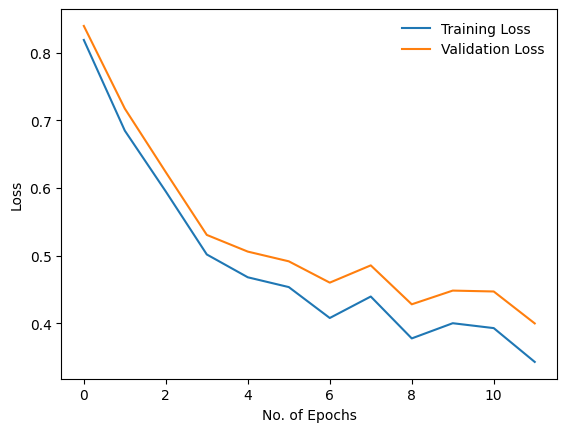

In [19]:
plt.plot(training_history['loss'],label="Training Loss")
plt.plot(validation_history['loss'],label="Validation Loss")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk
Loading the saved pytorch model from the disk for inferencing.

In [20]:
# loading the saved model
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    from pathlib import Path
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return Path(model_save_path) / checkpoint_files[last_idx]

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
print("Model Loaded")

Model Loaded


### Refrences 
* [Pytorch Ignite Text CNN example notebook](https://github.com/pytorch/ignite/blob/master/examples/notebooks/TextCNN.ipynb)
* [Pytorch Ignite MNIST example](https://github.com/pytorch/ignite/blob/master/examples/mnist/mnist.py)